In [1]:
#data
import pandas as pd
import os
import json
import numpy as np

In [2]:
#plotting
import matplotlib
import seaborn as sns
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
from matplotlib_venn import venn2, venn2_circles, venn2_unweighted
from matplotlib_venn import venn3, venn3_circles
from matplotlib import pyplot as plt
import matplotlib.patches as mpatches

/cellar/users/mpagadal/Programs/miniconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
def Merge(dict1, dict2):
    '''
    Function to merge python dictionaries
    '''
    res = {**dict1, **dict2}
    return res

In [4]:
def format4vep(snps,col):
    '''
    Function to format for VEP
    '''
    vep=pd.DataFrame({"snps":snps[col]})
    vep=vep["snps"].str.split(":",expand=True)
    vep[3]=vep[3].astype(str)+"/"+vep[2].astype(str)
    vep[2]=vep[1]
    vep[4]="+"
    vep[5]=snps[col]
    vep[0]=vep[0].str.replace("X","23")
    vep[0]=pd.to_numeric(vep[0])
    vep[1]=pd.to_numeric(vep[1])
    vep[2]=pd.to_numeric(vep[2])
    
    vep=vep.sort_values(by=[0, 2])
    vep[0]=vep[0].astype(str)
    return(vep)

In [5]:
with open('/cellar/users/mpagadal/resources/tcga/ensembl_map.json', 'r') as f:
    ensembl = json.load(f)
ensembl={k.split(".")[0]:v for k,v in ensembl.items()}

## Get significant PLINK associations

In [6]:
# get significant associations
direct="../data/clumps/"
files=[x for x in os.listdir(direct) if "sig" in x]

compiled_df=pd.DataFrame()
for x in files:
    try:
        df=pd.read_csv(direct+x)
        df["pheno"]=x.split(".")[0]
        compiled_df=compiled_df.append(df)
    except:
        pass
    
compiled_df["group"]=compiled_df["file"].str.split(".").str[0]
compiled_df=compiled_df[["CHR","F","SNP","BP","P","pheno","group"]]

#get corresponding summary stats
direct="../data/summarystats/extract/"
compiled_stats=pd.DataFrame()
for x in [x for x in os.listdir(direct)]:
    df=pd.read_csv(direct+x,delimiter="\t")
    df["file"]=x
    df["pheno"]=x.split(".")[2]
    df["group"]=x.split(".")[1]
    if x.split(".")[2]=="hypogonad":
        df["BETA"]=np.log(df["OR"])
        df["SE"]=df["LOG(OR)_SE"]
    compiled_stats=compiled_stats.append(df)
compiled_stats["SNP"]=compiled_stats["ID"]
compiled_df=pd.merge(compiled_df,compiled_stats[["SNP","pheno","A1","BETA","SE","group"]], on=["SNP","pheno","group"],how="left")

In [7]:
all_snps=compiled_df["SNP"].unique().tolist()
liftover=pd.DataFrame({"snps":all_snps})
liftover["snps"]=liftover["snps"].str.replace("chr","")
liftover["chr"]=liftover["snps"].str.split(":").str[0]
liftover["bp"]=liftover["snps"].str.split(":").str[1]
liftover["bp"]=liftover["bp"].astype(int)
liftover["bp2"]=liftover["bp"]+1
liftover["chr"]="chr"+liftover["chr"]
liftover[["chr","bp","bp2","snps"]].to_csv("testosterone.hg38.bed",index=None,header=None,sep="\t")
lifted=pd.read_csv("testosterone.hg19.bed",header=None,delimiter="\t")
lifted["hg19"]=lifted[3].str.split(":").str[0]+":"+lifted[1].astype(str)+":"+lifted[3].str.split(":").str[2]+":"+lifted[3].str.split(":").str[3]
snps=lifted["hg19"].tolist()+[x.rsplit(":",2)[0]+":"+x.split(":")[3]+":"+x.split(":")[2] for x in lifted["hg19"]]
pd.DataFrame({"snps":snps})["snps"].to_csv("../data/extract.testosterone.snps.hg19.txt",header=None,index=None)

## Add VEP information

### make VEP input

In [8]:
compiled_df["SNP"]=compiled_df["SNP"].str.replace("chr","")
vep_input=format4vep(compiled_df,"SNP")
vep_input.to_csv("../data/vep/vep_input.txt",header=None,index=None,sep="\t")

In [9]:
len(compiled_df["SNP"].unique())

247

### load VEP output

In [10]:
vep_output=pd.read_csv("../data/vep/VLFPLxjctfDm4OT3.txt",delimiter="\t")
df_consequence=vep_output[["#Uploaded_variation","Consequence"]].drop_duplicates().groupby('#Uploaded_variation')['Consequence'].apply(lambda x: ','.join(x)).reset_index()
df_gene=vep_output[["#Uploaded_variation","SYMBOL"]].drop_duplicates().groupby('#Uploaded_variation')['SYMBOL'].apply(lambda x: ','.join(x)).reset_index()

In [11]:
annotated=vep_output[vep_output["SYMBOL"]!="-"]["#Uploaded_variation"].unique()

In [12]:
missense_variants=vep_output[vep_output["Consequence"].str.contains("missense")]["#Uploaded_variation"].unique().tolist()

In [13]:
df_consequence=vep_output[["#Uploaded_variation","Consequence"]].drop_duplicates().groupby('#Uploaded_variation')['Consequence'].apply(lambda x: ','.join(x)).reset_index()
df_gene=vep_output[["#Uploaded_variation","SYMBOL"]].drop_duplicates().groupby('#Uploaded_variation')['SYMBOL'].apply(lambda x: ','.join(x)).reset_index()
mp_consequence=dict(zip(df_consequence["#Uploaded_variation"],df_consequence["Consequence"]))
mp_gene=dict(zip(df_gene["#Uploaded_variation"],df_gene["SYMBOL"]))
compiled_df["consequence"]=compiled_df["SNP"].map(mp_consequence)
compiled_df["gene"]=compiled_df["SNP"].map(mp_gene)
compiled_df["missense"]=np.where(compiled_df["SNP"].isin(missense_variants),"missense","")

In [14]:
len(missense_variants)

10

## Get trans-ancestry dataframe

In [15]:
trans=compiled_df[compiled_df["group"]=="all"]
trans=trans.fillna("")

In [16]:
len(trans["SNP"].unique())

145

### Add SuSIE Causality Information

In [17]:
susie=pd.read_csv("../data/susie/compiled.susie.csv")
susie["SNP"]=susie["SNP"].str.replace("_",":")
susie_lst=[]

for i,row in trans.iterrows():
    susie_pheno=susie[susie["group"]==row["group"]]
    susie_pheno=susie_pheno[susie_pheno["SNP"].str.contains(row["pheno"])]
    susie_pheno=susie_pheno[susie_pheno["SNP"].str.contains(row["SNP"].rsplit(";",2)[0])]
    susie_pheno=susie_pheno[susie_pheno["ID"].str.contains(row["SNP"].rsplit(";",2)[0])]
    susie_pheno=susie_pheno[susie_pheno["fit.pip"]>=0.05]
    if len(susie_pheno)>0:
        susie_lst.append(susie_pheno["fit.pip"].tolist()[0])
    else:
        susie_lst.append("NA")
trans["susie"]=susie_lst

In [18]:
trans.to_csv("../supplemental/tables1.csv")

### Export associations to networkx for visualization

In [19]:
node1=[]
node2=[]

for i,row in trans.iterrows():
    try:
        for gene in row["gene"].split(","):
            node1.append(row["SNP"])
            node2.append(gene)
        node1.append(row["SNP"])
        node2.append(row["pheno"])
    
    except:
        
        node1.append(row["SNP"])
        node2.append(row["pheno"])

df=pd.DataFrame({"node1":node1,"node2":node2})
df=df[df["node2"]!="-"]
df=df.drop_duplicates()
df.to_csv("../data/networkx/networkx.csv",index=None)

nodes=[x for x in set(node1)]+[x for x in set(node2)]
df_node=pd.DataFrame({"nodes":nodes})
df_node["type"]=np.where(df_node['nodes'].str.contains(":"),"snp","gene")
df_node["type"]=np.where(df_node["nodes"].isin(["shbg","hypogonad","free","total"]),"pheno",df_node["type"])
df_node["display_name"]=np.where(df_node["nodes"].str.contains(":"),"",df_node["nodes"])

df_pheno_counts=trans["pheno"].value_counts().reset_index()
mp_pheno_size=dict(zip(df_pheno_counts["index"],df_pheno_counts["pheno"]))

node1=[]
node2=[]

for i,row in trans.iterrows():
    try:
        for gene in row["gene"].split(","):
            node1.append(row["pheno"])
            node2.append(gene)
    except:
        pass    

df_gene_counts=pd.DataFrame({"node1":node1,"node2":node2})
df_gene_counts=df_gene_counts[df_gene_counts["node2"]!="-"]
df_gene_counts=df_gene_counts.drop_duplicates()
df_gene_counts=df_gene_counts["node2"].value_counts().reset_index()
mp_gene_size=dict(zip(df_gene_counts["index"],df_gene_counts["node2"]))
mp_size=Merge(mp_pheno_size,mp_gene_size)
df_node["size"]=df_node["nodes"].map(mp_size).fillna(0)
df_node.to_csv("../data/networkx/networkx.node.csv",index=None)

### look at effect sizes across ancestry groups

In [20]:
def format_clustermap(stats_df, trans_df, pheno):
    # get trans-ancestry SNPs
    trans_df["ID"]="chr"+trans_df["SNP"]
    compiled_stats_group=stats_df[stats_df["SNP"].isin(trans_df[trans_df["pheno"]==pheno]["ID"].tolist())]
    compiled_stats_group=compiled_stats_group[compiled_stats_group["pheno"]==pheno]
    
    compiled_stats_group_oriented=pd.DataFrame()
    #orient SNPs correctly
    for x in compiled_stats_group["ID"].unique():
        a1=compiled_stats_group[compiled_stats_group["ID"]==x]["A1"].value_counts().reset_index()["index"].tolist()[0]
        compiled_stats_snp=compiled_stats_group[compiled_stats_group["ID"]==x]
        compiled_stats_snp["BETA"]=np.where(compiled_stats_snp["A1"]!=a1,compiled_stats_snp["BETA"]*-1,compiled_stats_snp["BETA"])
        compiled_stats_snp["A1"]=a1
        compiled_stats_group_oriented=compiled_stats_group_oriented.append(compiled_stats_snp)
    return(compiled_stats_group_oriented)
#     return(compiled_stats_group_oriented.pivot(index="group",columns="ID",values="BETA"))  

In [21]:
compiled_stats_noall=compiled_stats[compiled_stats["group"]!="all"]

In [22]:
def heatmap(x, y, size,color):
    fig, ax = plt.subplots(figsize=(25, 5))
    
    # Mapping from column names to integer coordinates
    x_labels = [v for v in x.unique()]
    y_labels = [v for v in y.unique()]
    x_to_num = {p[1]:p[0] for p in enumerate(x_labels)} 
    y_to_num = {p[1]:p[0] for p in enumerate(y_labels)} 
    
    size_scale = 10
    plt.scatter(
        x=x.map(x_to_num), # Use mapping for x
        y=y.map(y_to_num), # Use mapping for y
        s=size * size_scale, 
        c=color,
        cmap="RdBu_r", vmin=-.5, vmax=.5# Vector of square sizes, proportional to size parameter
    )
    
    # Show column labels on the axes
    ax.set_xticks([x_to_num[v] for v in x_labels])
    ax.set_xticklabels(x_labels, rotation=45, horizontalalignment='right')
    ax.set_yticks([y_to_num[v] for v in y_labels])
    ax.set_yticklabels(y_labels)
    plt.colorbar()
    
    plt.xticks(rotation=90)

/tmp/ipykernel_2238060/3842155894.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  compiled_stats_snp["BETA"]=np.where(compiled_stats_snp["A1"]!=a1,compiled_stats_snp["BETA"]*-1,compiled_stats_snp["BETA"])
/tmp/ipykernel_2238060/3842155894.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  compiled_stats_snp["A1"]=a1


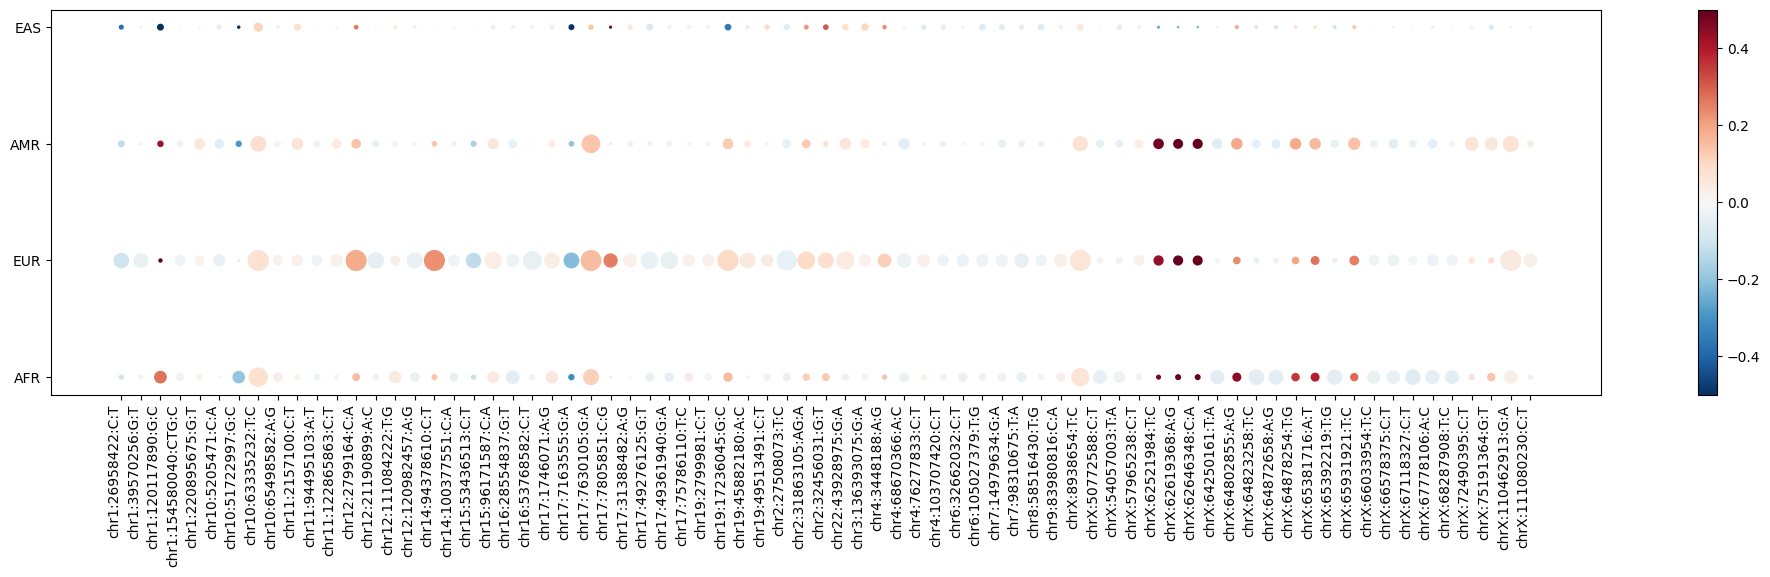

In [23]:
df_plot=format_clustermap(compiled_stats_noall, trans, "total")
df_plot["-log10p"]=-np.log10(df_plot["P"])
df_plot["-log10p"]=np.where(df_plot["-log10p"]>20,20,df_plot["-log10p"])    

heatmap(
    x=df_plot['ID'],
    y=df_plot['group'],
    size=df_plot['-log10p'],
    color=df_plot['BETA'],
)
plt.savefig("../plots/total.clustermap.pdf")

/tmp/ipykernel_2238060/3842155894.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  compiled_stats_snp["BETA"]=np.where(compiled_stats_snp["A1"]!=a1,compiled_stats_snp["BETA"]*-1,compiled_stats_snp["BETA"])
/tmp/ipykernel_2238060/3842155894.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  compiled_stats_snp["A1"]=a1


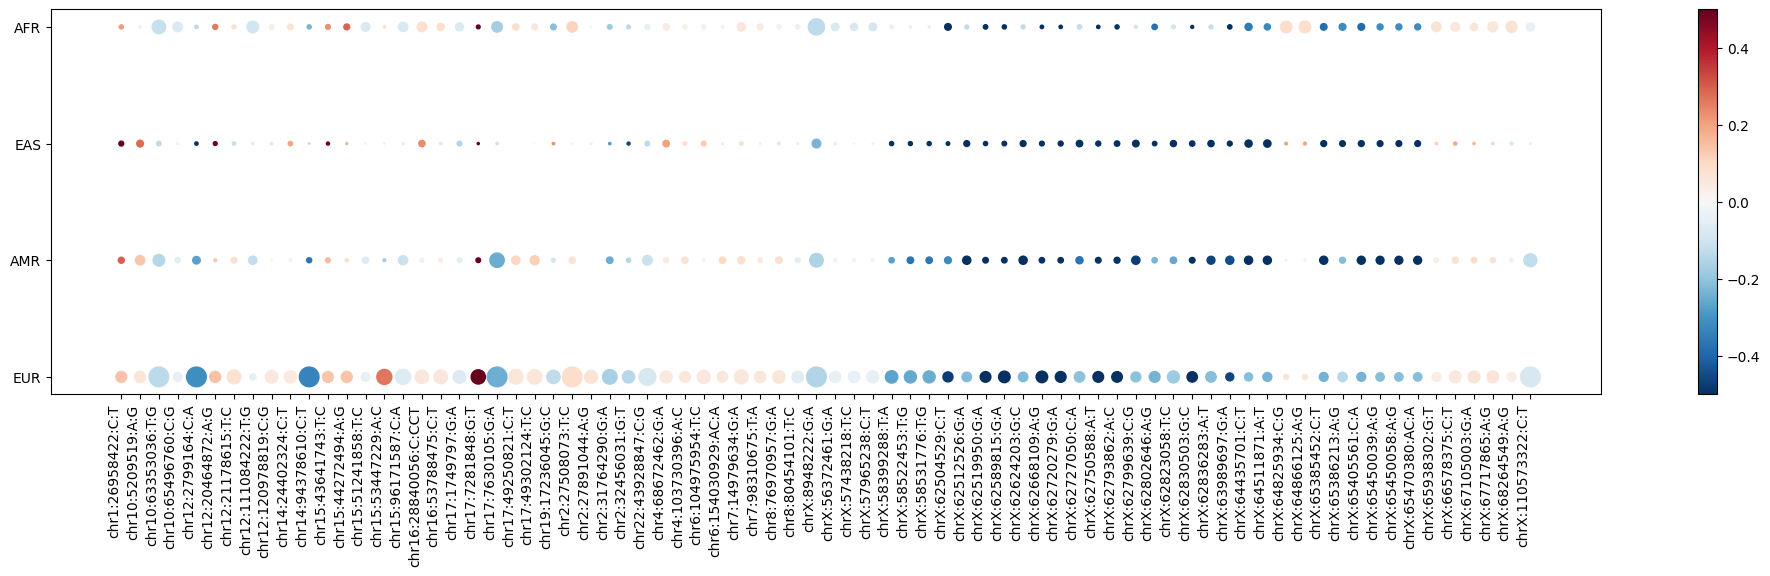

In [24]:
df_plot=format_clustermap(compiled_stats_noall, trans, "hypogonad")
df_plot["-log10p"]=-np.log10(df_plot["P"])
df_plot["-log10p"]=np.where(df_plot["-log10p"]>20,20,df_plot["-log10p"])

heatmap(
    x=df_plot['ID'],
    y=df_plot['group'],
    size=df_plot['-log10p'],
    color=df_plot['BETA'],
)
plt.savefig("../plots/hypogonad.clustermap.pdf")

/tmp/ipykernel_2238060/3842155894.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  compiled_stats_snp["BETA"]=np.where(compiled_stats_snp["A1"]!=a1,compiled_stats_snp["BETA"]*-1,compiled_stats_snp["BETA"])
/tmp/ipykernel_2238060/3842155894.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  compiled_stats_snp["A1"]=a1


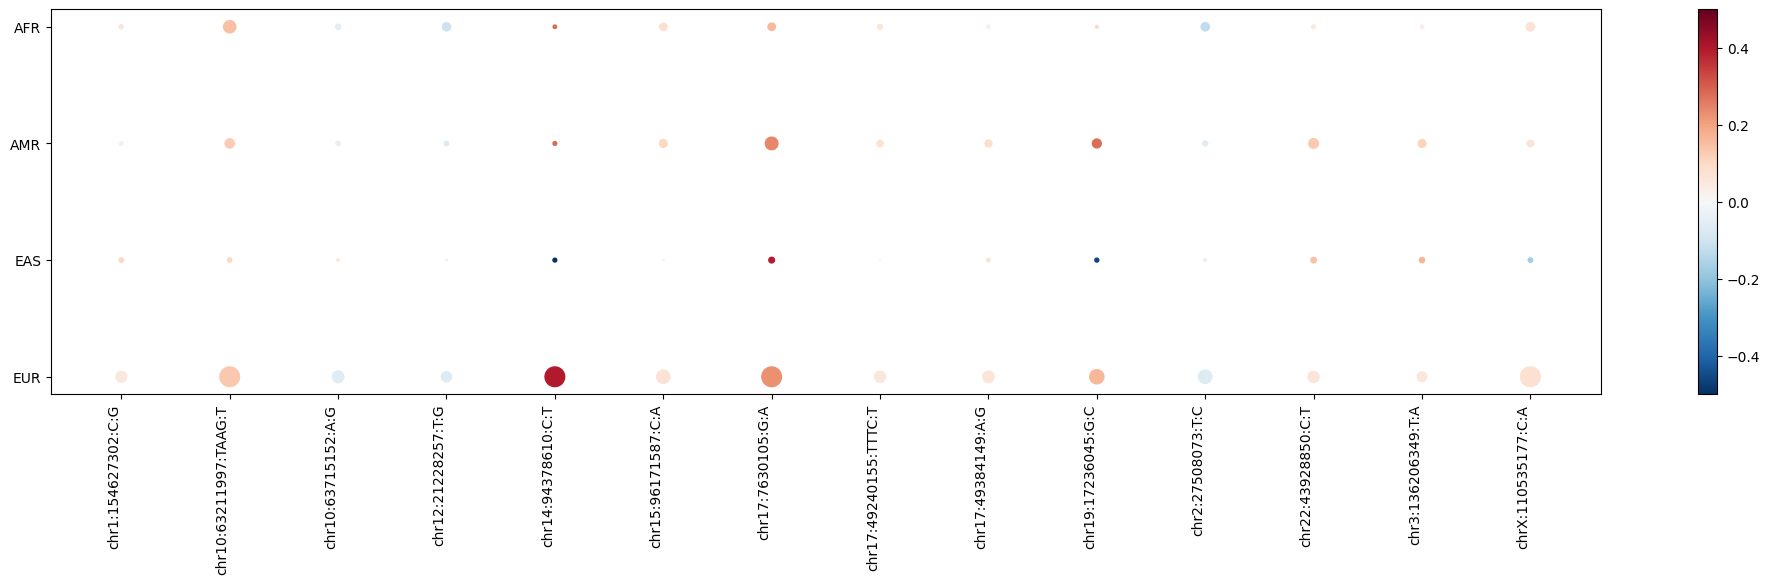

In [25]:
df_plot=format_clustermap(compiled_stats_noall, trans, "shbg")
df_plot["-log10p"]=-np.log10(df_plot["P"])
df_plot["-log10p"]=np.where(df_plot["-log10p"]>20,20,df_plot["-log10p"])

heatmap(
    x=df_plot['ID'],
    y=df_plot['group'],
    size=df_plot['-log10p'],
    color=df_plot['BETA'],
)
plt.savefig("../plots/shbg.clustermap.pdf")

### Check for concordance

In [26]:
compiled_stats_noall["SNP"]=compiled_stats_noall["ID"].str.split("chr").str[1]

/tmp/ipykernel_2238060/3712598294.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  compiled_stats_noall["SNP"]=compiled_stats_noall["ID"].str.split("chr").str[1]


In [96]:
check=pd.DataFrame()

for i,row in trans.iterrows():
    
    compiled_stats_group=compiled_stats_noall[compiled_stats_noall["SNP"]==row["SNP"]]
    compiled_stats_group=compiled_stats_group[compiled_stats_group["pheno"]==row["pheno"]]
    
    a1=compiled_stats_group[compiled_stats_group["SNP"]==row["SNP"]]["A1"].value_counts().reset_index()["index"].tolist()[0]
    compiled_stats_group["BETA"]=np.where(compiled_stats_group["A1"]!=a1,compiled_stats_group["BETA"]*-1,compiled_stats_group["BETA"])
    compiled_stats_group["A1"]=a1
    
    if (len(compiled_stats_group[compiled_stats_group["BETA"]>0])==0) | (len(compiled_stats_group[compiled_stats_group["BETA"]<0])==0):
        pass
    else:
#         if row["BETA"]>0:
#             df=compiled_stats_group[compiled_stats_group["BETA"]<0]
#             df["upper"]=df["BETA"]+(1.96*df["SE"])
#             df["lower"]=df["BETA"]-(1.96*df["SE"])
            
#             if (len(df[(df["upper"]>0)&(df["lower"]>0)])>0)|(len(df[(df["upper"]<0)&(df["lower"]<0)])>0):
#                 print(row[["SNP","BETA","P","pheno"]])
#                 print(df[["SNP","BETA","P","group"]])
        
#         if row["BETA"]<0:
#             df=compiled_stats_group[compiled_stats_group["BETA"]>0]
#             df["upper"]=df["BETA"]+(1.96*df["SE"])
#             df["lower"]=df["BETA"]-(1.96*df["SE"])
            
#             if (len(df[(df["upper"]>0)&(df["lower"]>0)])>0)|(len(df[(df["upper"]<0)&(df["lower"]<0)])>0):
#                 print(row[["SNP","BETA","P","pheno"]])
#                 print(df[["SNP","BETA","P","group"]])
        check=check.append(compiled_stats_group)

In [100]:
check["ID"].unique()

array(['chr10:65496760:C:G', 'chr12:21178615:T:C', 'chr12:120978819:C:G',
       'chr15:53447229:A:C', 'chr19:17236045:G:C', 'chr2:27508073:T:C',
       'chr2:27891044:A:G', 'chr6:154030929:AC:A', 'chrX:68264549:A:G',
       'chr1:39570256:G:T', 'chr1:120117890:G:C', 'chr1:154580040:CTG:C',
       'chr10:65498582:A:G', 'chr11:94495103:A:T', 'chr11:122865863:C:T',
       'chr12:21190899:A:C', 'chr12:120982457:A:G', 'chr14:94378610:C:T',
       'chr14:100377551:C:A', 'chr15:53436513:C:T', 'chr17:75786110:T:C',
       'chr19:2799981:C:T', 'chr19:45882180:A:C', 'chr4:76277833:C:T',
       'chrX:62521984:T:C', 'chrX:57965238:C:T', 'chrX:62646348:C:A',
       'chrX:62619368:A:G', 'chrX:66578375:C:T', 'chrX:75191364:G:T',
       'chrX:111080230:C:T', 'chr10:63715152:A:G', 'chr12:21228257:T:G',
       'chr17:49240155:TTTC:T', 'chrX:110535177:C:A'], dtype=object)

In [102]:
check[check["P"]<.05]

,#CHROM,POS,ID,REF,ALT,A1,TEST,OBS_CT,BETA,SE,...,P,ERRCODE,file,pheno,group,FIRTH?,OR,LOG(OR)_SE,Z_STAT,SNP
6,10,65496760,chr10:65496760:C:G,C,G,G,ADD,102635,-0.035267,0.009027,...,9.355360e-05,.,compiled.EUR.hypogonad.v2.extract.testosterone...,hypogonad,EUR,N,0.965348,0.009027,-3.90673,10:65496760:C:G
6,10,65496760,chr10:65496760:C:G,C,G,G,ADD,13328,-0.055371,0.027169,...,4.154310e-02,.,compiled.AMR.hypogonad.v2.extract.testosterone...,hypogonad,AMR,N,0.946134,0.027169,-2.03807,10:65496760:C:G
6,10,65496760,chr10:65496760:C:G,C,G,G,ADD,27736,-0.074921,0.017436,...,1.732380e-05,.,compiled.AFR.hypogonad.v2.extract.testosterone...,hypogonad,AFR,N,0.927817,0.017436,-4.29686,10:65496760:C:G
11,12,21178615,chr12:21178615:T:C,T,C,C,ADD,102635,0.077951,0.012154,...,1.425540e-10,.,compiled.EUR.hypogonad.v2.extract.testosterone...,hypogonad,EUR,N,1.081070,0.012154,6.41314,12:21178615:T:C
11,12,21178615,chr12:21178615:T:C,T,C,C,ADD,13328,0.084580,0.037781,...,2.518010e-02,.,compiled.AMR.hypogonad.v2.extract.testosterone...,hypogonad,AMR,N,1.088260,0.037781,2.23863,12:21178615:T:C
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15,19,17236045,chr19:17236045:G:C,G,C,C,ADD,13910,0.167764,0.025391,...,4.059220e-11,.,compiled.EUR.shbg.v2.extract.testosterone.glm....,shbg,EUR,NaN,NaN,NaN,NaN,19:17236045:G:C
15,19,17236045,chr19:17236045:G:C,G,C,C,ADD,2087,0.280064,0.071132,...,8.514780e-05,.,compiled.AMR.shbg.v2.extract.testosterone.glm....,shbg,AMR,NaN,NaN,NaN,NaN,19:17236045:G:C
24,X,110535177,chrX:110535177:C:A,C,A,A,ADD,13910,0.081790,0.008015,...,2.301240e-24,.,compiled.EUR.shbg.v2.extract.testosterone.glm....,shbg,EUR,NaN,NaN,NaN,NaN,X:110535177:C:A
24,X,110535177,chrX:110535177:C:A,C,A,A,ADD,2087,0.065871,0.023294,...,4.732140e-03,.,compiled.AMR.shbg.v2.extract.testosterone.glm....,shbg,AMR,NaN,NaN,NaN,NaN,X:110535177:C:A


### get pleiotropic variants

In [28]:
duplicated_snps=trans[trans.duplicated(['SNP'], keep=False)]["SNP"].unique().tolist()

In [29]:
len(duplicated_snps)

14

In [30]:
for x in duplicated_snps:
    print(x)
    print(trans[trans["SNP"]==x]["pheno"].tolist())
    print(trans[trans["SNP"]==x]["missense"].tolist())

1:26958422:C:T
['hypogonad', 'total']
['', '']
12:2799164:C:A
['hypogonad', 'total']
['missense', 'missense']
12:111084222:T:G
['hypogonad', 'total']
['', '']
14:94378610:C:T
['hypogonad', 'total', 'shbg']
['missense', 'missense', 'missense']
15:96171587:C:A
['hypogonad', 'total', 'shbg']
['', '', '']
17:7630105:G:A
['hypogonad', 'total', 'shbg']
['', '', '']
19:17236045:G:C
['hypogonad', 'total', 'shbg']
['missense', 'missense', 'missense']
2:27508073:T:C
['hypogonad', 'total', 'shbg']
['missense', 'missense', 'missense']
2:32456031:G:T
['hypogonad', 'total']
['', '']
7:14979634:G:A
['hypogonad', 'total']
['', '']
7:98310675:T:A
['hypogonad', 'total']
['', '']
X:8948222:G:A
['hypogonad', 'free']
['', '']
X:57965238:C:T
['hypogonad', 'total']
['', '']
X:66578375:C:T
['hypogonad', 'total']
['', '']


## Get ancestry-specific variants

In [31]:
ancestry=compiled_df[compiled_df["group"]!="all"]
ancestry["ID"]="chr"+ancestry["SNP"]

specificity=[]
for i,row in ancestry.iterrows():
    check=trans[trans["CHR"]==int(row["CHR"])]
    check=check[check["pheno"]==row["pheno"]]
    check["diff"]=abs(check["BP"]-row["BP"])
    check=check[check["diff"]<=500000]
    
    if len(check)>0:
        specificity.append(check.sort_values(by="diff")["SNP"].tolist()[0])
    else:
        specificity.append(">500kb")
        
ancestry["specificity"]=specificity

/tmp/ipykernel_2238060/4059981845.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ancestry["ID"]="chr"+ancestry["SNP"]
/tmp/ipykernel_2238060/4059981845.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ancestry["specificity"]=specificity


### Determine if ancestry-specific variants are significant in trans-ancestry analysis

In [32]:
compiled_stats_all_sig=compiled_stats[compiled_stats["group"]=="all"]
all_sig=[]

for i,row in ancestry.iterrows():
    check=compiled_stats_all_sig[compiled_stats_all_sig["ID"]==row["ID"]]
    check=check[check["pheno"]==row["pheno"]]
    if check["P"].tolist()[0] < .00000005:
        all_sig.append("sig")
    else:
        all_sig.append("")
ancestry["all_sig"]=all_sig

/tmp/ipykernel_2238060/793984314.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ancestry["all_sig"]=all_sig


In [33]:
ancestry["SNP"]="chr"+ancestry["SNP"]
ancestry_filter=ancestry[ancestry["all_sig"]==""]

/tmp/ipykernel_2238060/2694102167.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ancestry["SNP"]="chr"+ancestry["SNP"]


In [34]:
compiled_stats_ancestry=compiled_stats[compiled_stats["SNP"].isin(ancestry["SNP"].tolist())]

compiled_stats_ancestry_oriented=pd.DataFrame()
#orient SNPs correctly
for x in compiled_stats_ancestry["ID"].unique():
    a1=compiled_stats_ancestry[compiled_stats_ancestry["ID"]==x]["A1"].value_counts().reset_index()["index"].tolist()[0]
    compiled_stats_snp=compiled_stats_ancestry[compiled_stats_ancestry["ID"]==x]
    compiled_stats_snp["BETA"]=np.where(compiled_stats_snp["A1"]!=a1,compiled_stats_snp["BETA"]*-1,compiled_stats_snp["BETA"])
    compiled_stats_snp["A1"]=a1
    compiled_stats_ancestry_oriented=compiled_stats_ancestry_oriented.append(compiled_stats_snp)

/tmp/ipykernel_2238060/458220321.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  compiled_stats_snp["BETA"]=np.where(compiled_stats_snp["A1"]!=a1,compiled_stats_snp["BETA"]*-1,compiled_stats_snp["BETA"])
/tmp/ipykernel_2238060/458220321.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  compiled_stats_snp["A1"]=a1


In [35]:
group_map={"all":0,"EUR":1,"AFR":2,"AMR":3,"EAS":4}

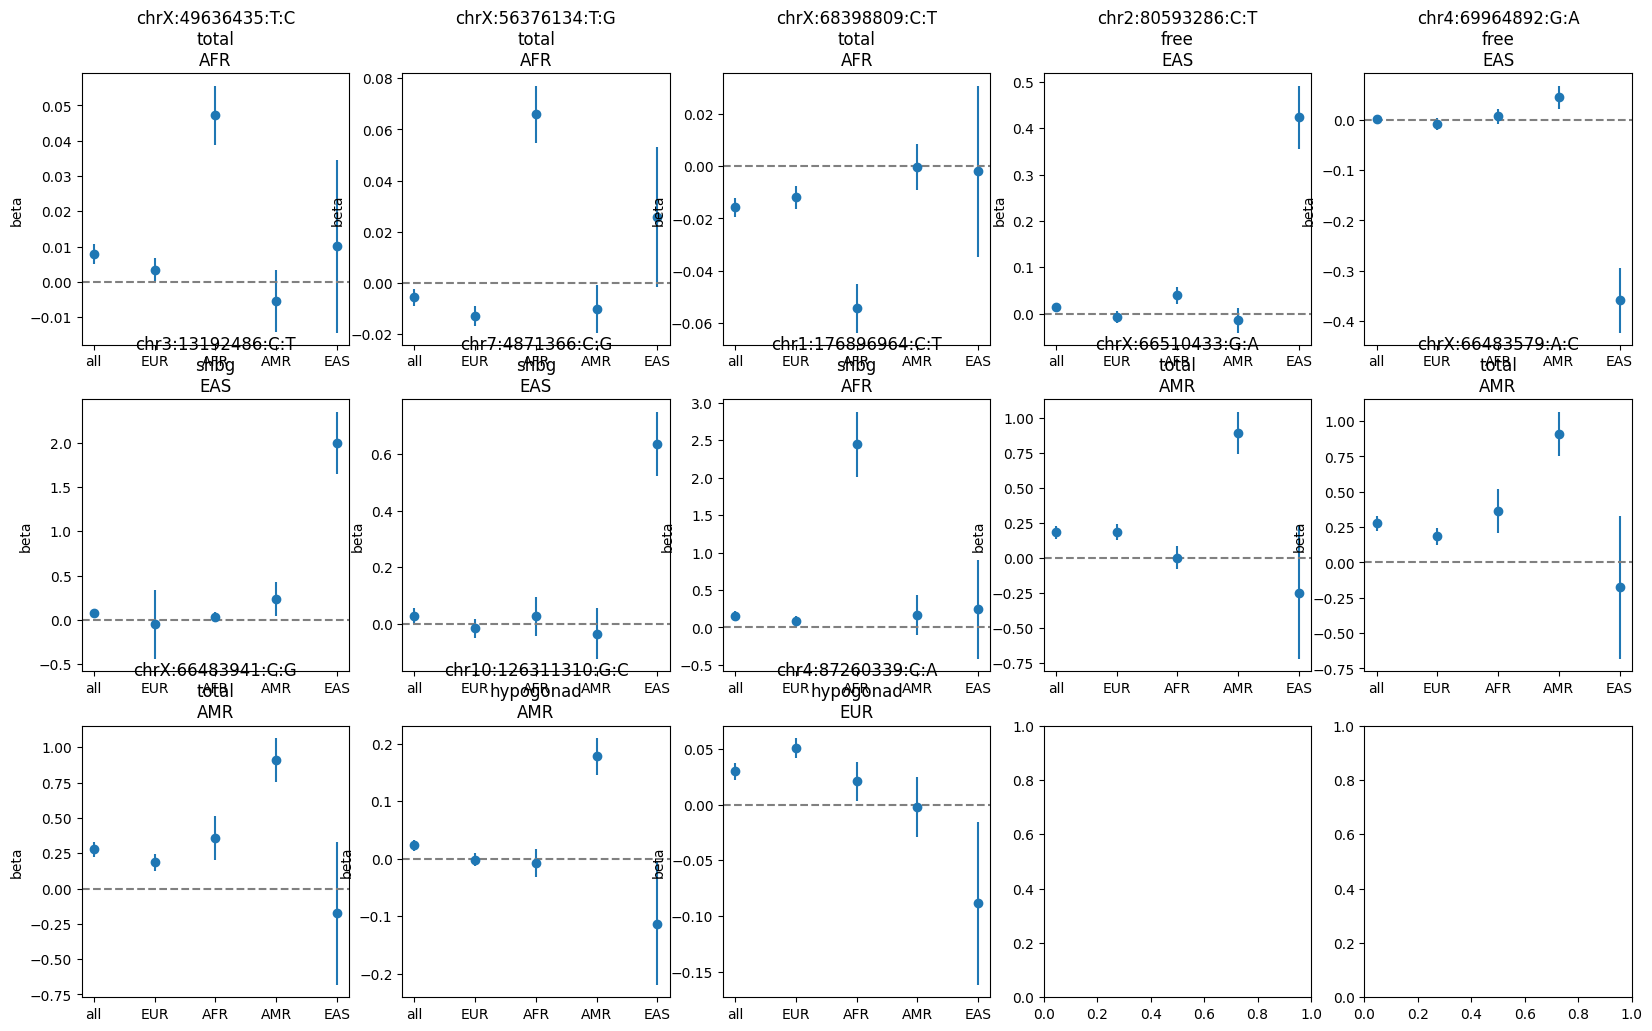

In [36]:
count=0
ancestry_beta_lst=[]
fig, axs = plt.subplots(3, 5, figsize=(20, 12))
axli = axs.flatten()

for i,row in ancestry_filter.iterrows():
    
    #plot beta and SE for each SNP
    df_snp=compiled_stats_ancestry_oriented[compiled_stats_ancestry_oriented["ID"]==row["SNP"]]
    df_snp=df_snp[df_snp["pheno"]==row["pheno"]]
    df_snp["index"]=df_snp["group"].map(group_map)
    df_snp=df_snp.sort_values(by="index")
    
    #check standard error bounds
    df_snp["Upper"]=df_snp["BETA"]+df_snp["SE"]
    df_snp["Lower"]=df_snp["BETA"]-df_snp["SE"]
    
    thresh=df_snp[df_snp["group"]==row["group"]]
    thresh_upper=thresh["Upper"].tolist()[0]
    thresh_lower=thresh["Lower"].tolist()[0]
    
    df_check=df_snp[df_snp["group"]!=row["group"]]
    
    if len(df_check[df_check["Upper"]>thresh_lower])==0:
        ancestry_beta_lst.append(row["SNP"])
        axli[count].set_title(row["SNP"]+"\n"+row["pheno"]+"\n"+row["group"])
        axli[count].errorbar(x="group",y="BETA",yerr="SE",data=df_snp,fmt="o")
        axli[count].axhline(0, linestyle="--",color="gray")
        axli[count].set_ylabel("beta")
        count+=1
        
    if len(df_check[df_check["Lower"]<thresh_upper])==0: 
        ancestry_beta_lst.append(row["SNP"])
        axli[count].set_title(row["SNP"]+"\n"+row["pheno"]+"\n"+row["group"])
        axli[count].errorbar(x="group",y="BETA",yerr="SE",data=df_snp,fmt="o")
        axli[count].axhline(0, linestyle="--",color="gray")
        axli[count].set_ylabel("beta")
        count+=1
        
plt.savefig("figs3.3.pdf")

In [37]:
# count=0
# ancestry_beta_lst=[]
# fig, axs = plt.subplots(5, 5, figsize=(20, 12))
# axli = axs.flatten()

# for i,row in ancestry_filter.iterrows():
    
#     #plot beta and SE for each SNP
#     df_snp=compiled_stats_ancestry_oriented[compiled_stats_ancestry_oriented["ID"]==row["SNP"]]
#     df_snp=df_snp[df_snp["pheno"]==row["pheno"]]
#     df_snp["index"]=df_snp["group"].map(group_map)
#     df_snp=df_snp.sort_values(by="index")
    
#     #check standard error bounds
#     df_snp["Upper"]=df_snp["BETA"]+(1.96*df_snp["SE"])
#     df_snp["Lower"]=df_snp["BETA"]-(1.96*df_snp["SE"])
    
#     thresh=df_snp[df_snp["group"]==row["group"]]
#     thresh_upper=thresh["Upper"].tolist()[0]
#     thresh_lower=thresh["Lower"].tolist()[0]
    
#     df_check=df_snp[df_snp["group"]!=row["group"]]
    
#     if len(df_check[(df_check["BETA"]>thresh_lower)&(df_check["BETA"]<thresh_upper)])==0:
#         ancestry_beta_lst.append(row["SNP"])
#         axli[count].set_title(row["SNP"]+"\n"+row["pheno"]+"\n"+row["group"])
#         axli[count].errorbar(x="group",y="BETA",yerr="SE",data=df_snp,fmt="o")
#         axli[count].axhline(0, linestyle="--",color="gray")
#         axli[count].set_ylabel("beta")
#         count+=1
        


In [38]:
# count=0

# fig, axs = plt.subplots(3, 5, figsize=(20, 12))
# axli = axs.flatten()

# for i,row in ancestry_filter[~ancestry_filter["SNP"].isin(ancestry_beta_lst)].iterrows():
    
#     if count < 15:
#         #plot beta and SE for each SNP
#         df_snp=compiled_stats_ancestry_oriented[compiled_stats_ancestry_oriented["ID"]==row["SNP"]]
#         df_snp=df_snp[df_snp["pheno"]==row["pheno"]]
#         df_snp["index"]=df_snp["group"].map(group_map)
#         df_snp=df_snp.sort_values(by="index")
    
#         axli[count].set_title(row["SNP"]+"\n"+row["pheno"]+"\n"+row["group"])
#         axli[count].errorbar(x="group",y="BETA",yerr="SE",data=df_snp,fmt="o")
#         axli[count].axhline(0, linestyle="--",color="gray")
#         axli[count].set_ylabel("beta")
#         count+=1
        
#     else:
#         pass
    
# plt.savefig("figs3.2.pdf")

In [39]:
# count=0

# fig, axs = plt.subplots(3, 5, figsize=(20, 12))
# axli = axs.flatten()

# for i,row in ancestry[~ancestry["SNP"].isin(ancestry_filter["SNP"].tolist())].iterrows():
    
#     if count < 15:
#         #plot beta and SE for each SNP
#         df_snp=compiled_stats_ancestry_oriented[compiled_stats_ancestry_oriented["ID"]==row["SNP"]]
#         df_snp=df_snp[df_snp["pheno"]==row["pheno"]]
#         df_snp["index"]=df_snp["group"].map(group_map)
#         df_snp=df_snp.sort_values(by="index")
    
#         axli[count].set_title(row["SNP"]+"\n"+row["pheno"]+"\n"+row["group"])
#         axli[count].errorbar(x="group",y="BETA",yerr="SE",data=df_snp,fmt="o")
#         axli[count].axhline(0, linestyle="--",color="gray")
#         axli[count].set_ylabel("beta")
#         count+=1
        
#     else:
#         pass
    
# plt.savefig("figs3.1.pdf")

### Get frequency

In [40]:
compiled_freq=pd.DataFrame()

for x in os.listdir("../data/maf/"):
    freq=pd.read_csv("../data/maf/"+x)
    freq["file"]=x
    compiled_freq=compiled_freq.append(freq)

compiled_freq["pheno"]=compiled_freq["file"].str.split(".").str[0]
compiled_freq["group"]=compiled_freq["file"].str.split(".").str[1]

In [41]:
compiled_freq[compiled_freq["ID"]=="chr1:26958422:C:T"]["group"].value_counts()

AFR    4
all    4
EUR    4
AMR    4
EAS    4
Name: group, dtype: int64

In [42]:
compiled_freq_pheno=compiled_freq[compiled_freq["pheno"]=="total"]

In [43]:
compiled_freq_final=pd.DataFrame()

for pheno in compiled_freq["pheno"].unique():
    compiled_freq_pheno=compiled_freq[compiled_freq["pheno"]==pheno]
    compiled_freq_pheno=compiled_freq_pheno.pivot(index="ID",columns="group",values="ALT_FREQS")
    compiled_freq_pheno=compiled_freq_pheno.reset_index()
    compiled_freq_pheno["pheno"]=pheno
    compiled_freq_final=compiled_freq_final.append(compiled_freq_pheno)

### Incorporate SuSIE causality analysis

In [44]:
susie=pd.read_csv("../data/susie/compiled.susie.csv")
susie["SNP"]=susie["SNP"].str.replace("_",":")
susie_lst=[]

for i,row in ancestry.iterrows():
    susie_pheno=susie[susie["group"]==row["group"]]
    susie_pheno=susie_pheno[susie_pheno["SNP"].str.contains(row["pheno"])]
    susie_pheno=susie_pheno[susie_pheno["SNP"].str.contains(row["SNP"].rsplit(";",2)[0])]
    susie_pheno=susie_pheno[susie_pheno["ID"].str.contains(row["SNP"].rsplit(";",2)[0])]
    susie_pheno=susie_pheno[susie_pheno["fit.pip"]>=susie_pheno["max.pip"]]
    
    if len(susie_pheno)>0:
        susie_lst.append(susie_pheno["fit.pip"].tolist()[0])
    else:
        susie_lst.append("NA")
ancestry["susie"]=susie_lst

/tmp/ipykernel_2238060/236434146.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ancestry["susie"]=susie_lst


In [45]:
ancestry["ancestry_beta"]=np.where(ancestry["SNP"].isin(ancestry_beta_lst),1,0)

/tmp/ipykernel_2238060/2240619074.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ancestry["ancestry_beta"]=np.where(ancestry["SNP"].isin(ancestry_beta_lst),1,0)


In [46]:
ancestry.to_csv("../supplemental/tables5.csv",index=None)

### Get PheWAS results

In [47]:
phewas=pd.read_csv("phewas.csv")

In [48]:
phewas["variant"]=phewas["snp"].str.replace("chr","")
phewas["variant"]=phewas["variant"].str.replace(".",":")
phewas["variant"]=phewas["variant"].str.rsplit(":",2).str[0]

/tmp/ipykernel_2238060/1675894986.py:2: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  phewas["variant"]=phewas["variant"].str.replace(".",":")


In [49]:
phewas=phewas[~phewas["phenotype"].isnull()]

In [50]:
phewas_annot=phewas.groupby('variant')['phenotype'].apply(lambda x: ','.join(x)).reset_index()

In [51]:
trans["variant"]=trans["SNP"].str.rsplit(":",2).str[0]
trans=pd.merge(trans,phewas_annot,on="variant",how="left")

In [52]:
len(trans[~trans["phenotype"].isnull()])

38

In [86]:
len(trans[~trans["phenotype"].isnull()]["SNP"].unique())

26

In [53]:
phewas_trans=phewas[phewas["variant"].isin(trans["variant"].tolist())]

In [54]:
ancestry["variant"]=ancestry["SNP"].str.rsplit(":",2).str[0]
ancestry["variant"]=ancestry["variant"].str.split("chr").str[1]

/tmp/ipykernel_2238060/2020287670.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ancestry["variant"]=ancestry["SNP"].str.rsplit(":",2).str[0]
/tmp/ipykernel_2238060/2020287670.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ancestry["variant"]=ancestry["variant"].str.split("chr").str[1]


### Get UKBB validation

In [55]:
ukbb_free=pd.read_csv("../data/ukbb/GCST90012103_buildGRCh37.tsv.gz",delimiter="\t")
ukbb_shbg=pd.read_csv("../data/ukbb/GCST90012109_buildGRCh37.tsv.gz",delimiter="\t")
ukbb_total=pd.read_csv("../data/ukbb/GCST90012113_buildGRCh37.tsv.gz",delimiter="\t")

In [56]:
lifted=pd.read_csv("testosterone.hg19.bed",header=None,delimiter="\t")
lifted["hg19_coord"]=lifted[0].astype(str)+":"+lifted[1].astype(str)
mp_hg19=dict(zip(lifted[3],lifted["hg19_coord"]))

In [57]:
ukbb_free["SNP"]="chr"+ukbb_free["chromosome"].astype(str)+":"+ukbb_free["base_pair_location"].astype(str)
ukbb_shbg["SNP"]="chr"+ukbb_shbg["chromosome"].astype(str)+":"+ukbb_shbg["base_pair_location"].astype(str)
ukbb_total["SNP"]="chr"+ukbb_total["chromosome"].astype(str)+":"+ukbb_total["base_pair_location"].astype(str)

In [58]:
# ukbb_free=ukbb_free[ukbb_free["SNP"].isin(trans[trans["pheno"]=="free"]["hg19_coord"].tolist())]
# ukbb_total=ukbb_total[ukbb_total["SNP"].isin(trans[trans["pheno"]=="total"]["hg19_coord"].tolist())]
# ukbb_shbg=ukbb_shbg[ukbb_shbg["SNP"].isin(trans[trans["pheno"]=="shbg"]["hg19_coord"].tolist())]

In [59]:
ukbb_free["pheno"]="free"
ukbb_total["pheno"]="total"
ukbb_shbg["pheno"]="shbg"

In [60]:
ukbb=ukbb_free.append(ukbb_total)
ukbb=ukbb.append(ukbb_shbg)

In [61]:
ukbb=ukbb.rename(columns={"SNP":"hg19_coord"})

In [62]:
ukbb=ukbb.drop([16245104])

In [63]:
trans["hg19_coord"]=trans["SNP"].map(mp_hg19)
trans["hg19_coord"]=trans["hg19_coord"].str.replace("chrX","chr23")

In [64]:
trans=pd.merge(trans,ukbb[["pheno","hg19_coord","variant_id","effect_allele","beta","standard_error","p_value"]],on=["pheno","hg19_coord"],how="left")

In [65]:
trans["beta"]=np.where(trans["A1"]!=trans["effect_allele"],trans["beta"]*-1,trans["beta"])

In [66]:
del trans["hg19_coord"]
del trans["effect_allele"]

In [67]:
trans["pheno"].value_counts()

hypogonad    76
total        73
shbg         14
free          1
Name: pheno, dtype: int64

In [68]:
trans=trans.rename(columns={"beta":"UKBB_BETA","standard_error":"UKBB_SE","p_value":"UKBB_P"})

In [69]:
trans[trans["UKBB_P"]<(.05/164)]["pheno"].value_counts()

total    54
shbg     13
free      1
Name: pheno, dtype: int64

In [70]:
trans[~trans["UKBB_P"].isnull()]["pheno"].value_counts()

total    63
shbg     13
free      1
Name: pheno, dtype: int64

In [71]:
trans[trans["UKBB_P"]>(.05/164)].to_csv("MVP.novel.variants.csv",index=None)

In [72]:
ancestry_eur=ancestry[ancestry["group"]=="EUR"]
ancestry_eur["SNP"]=ancestry_eur["SNP"].str.split("chr").str[1]

/tmp/ipykernel_2238060/1624393570.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ancestry_eur["SNP"]=ancestry_eur["SNP"].str.split("chr").str[1]


In [73]:
ancestry_eur["hg19_coord"]=ancestry_eur["SNP"].map(mp_hg19)
ancestry_eur["hg19_coord"]=ancestry_eur["hg19_coord"].str.replace("chrX","chr23")

/tmp/ipykernel_2238060/4137171367.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ancestry_eur["hg19_coord"]=ancestry_eur["SNP"].map(mp_hg19)
/tmp/ipykernel_2238060/4137171367.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ancestry_eur["hg19_coord"]=ancestry_eur["hg19_coord"].str.replace("chrX","chr23")


In [74]:
ancestry_eur=pd.merge(ancestry_eur,ukbb[["pheno","hg19_coord","variant_id","effect_allele","beta","standard_error","p_value"]],on=["pheno","hg19_coord"],how="left")

In [75]:
ancestry_eur["beta"]=np.where(ancestry_eur["A1"]!=ancestry_eur["effect_allele"],ancestry_eur["beta"]*-1,ancestry_eur["beta"])

In [76]:
del ancestry_eur["hg19_coord"]
del ancestry_eur["effect_allele"]

In [77]:
ancestry_eur["pheno"].value_counts()

hypogonad    51
total        37
shbg          7
free          3
Name: pheno, dtype: int64

In [78]:
ancestry_eur=ancestry_eur.rename(columns={"beta":"UKBB_BETA","standard_error":"UKBB_SE","p_value":"UKBB_P"})

In [79]:
ancestry_eur[ancestry_eur["UKBB_P"]<(.05/98)]["pheno"].value_counts()

total    32
shbg      7
free      1
Name: pheno, dtype: int64

In [80]:
ancestry_eur[~ancestry_eur["UKBB_P"].isnull()]["pheno"].value_counts()

total    34
shbg      7
free      1
Name: pheno, dtype: int64

### Get prs results

In [119]:
quantile=pd.read_csv("../data/coxph/compiled.quantile.results.csv")

In [120]:
quantile["quantile"]=quantile["quantile\tbeta\tse"].str.split("\t").str[0]
quantile["beta"]=quantile["quantile\tbeta\tse"].str.split("\t").str[1]
quantile["beta"]=quantile["beta"].astype(float)
quantile["se"]=quantile["quantile\tbeta\tse"].str.split("\t").str[2]
quantile["se"]=quantile["se"].astype(float)
quantile["PRS"]=quantile["file"].str.split(".").str[0]
quantile["group"]=quantile["file"].str.split(".").str[2]
quantile["pheno"]=quantile["file"].str.split(".").str[3]

/tmp/ipykernel_2238060/3662818694.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  quantile_pheno["beta"]=np.where(quantile_pheno["quantile"]!="5",np.exp(quantile_pheno["beta"]),quantile_pheno["beta"])


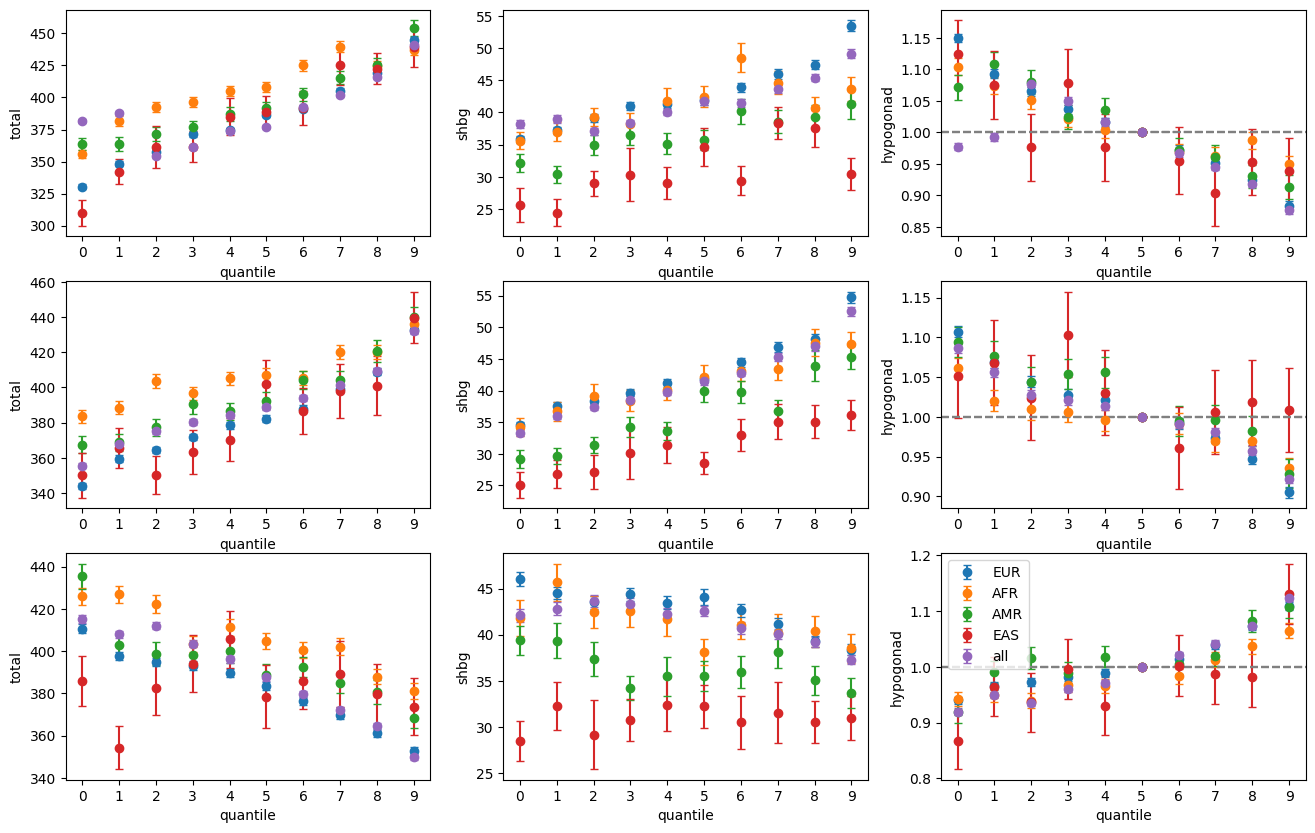

In [137]:
fig, axs = plt.subplots(3, 3, figsize=(16, 10))
axli = axs.flatten()

count=0
for x in ["total","shbg","hypogonad"]:
    for y in ["total","shbg","hypogonad"]:
        quantile_pheno=quantile[(quantile["PRS"]==x)&(quantile["pheno"]==y)]
        if y == "hypogonad":
            quantile_pheno["beta"]=np.where(quantile_pheno["quantile"]!="5",np.exp(quantile_pheno["beta"]),quantile_pheno["beta"])
            
        for group in ["EUR","AFR","AMR","EAS","all"]:
            quantile_pheno_group=quantile_pheno[quantile_pheno["group"]==group]
            axli[count].errorbar(quantile_pheno_group["quantile"].tolist(), quantile_pheno_group["beta"].tolist(),yerr=quantile_pheno_group["se"].tolist(),fmt="o",label=group,capsize=3)
            axli[count].set_xlabel("quantile")
            axli[count].set_ylabel(y)
            
            if y == "hypogonad":
                axli[count].axhline(1,linestyle="--",color="grey")
        count+=1
        
plt.legend()
plt.savefig("fig4.pdf")

### Get coxph results

In [138]:
coxph=pd.read_csv("../data/coxph/compiled.coxph.exclude.results.csv")

In [139]:
coxph["phecode"]=coxph["file"].str.split(".").str[1]
coxph["PRS"]=coxph["file"].str.split(".").str[0]
coxph["group"]=coxph["file"].str.split(".").str[2]
coxph["odds"]=np.exp(coxph["beta"])

In [140]:
coxph["group_order"]=coxph["group"].map({"all":1,"EUR":2,"AFR":3,"AMR":4,"EAS":5})

In [141]:
coxph["upper"]=coxph["odds"]+coxph["se"]
coxph["lower"]=coxph["odds"]-coxph["se"]

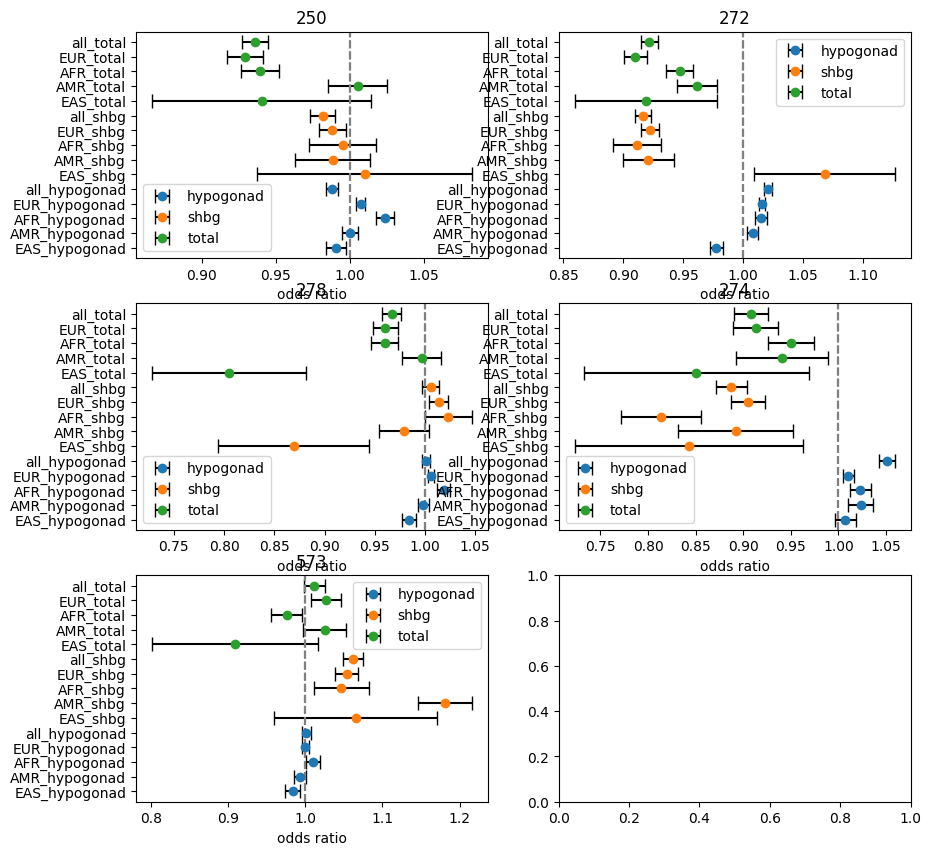

In [143]:
fig, axs = plt.subplots(3, 2, figsize=(10, 10))
axli = axs.flatten()

count=0
for y in ["250","272","278","274","573"]:
    for x in ["hypogonad","shbg","total"]:
        coxph_pheno=coxph[(coxph["PRS"]==x)&(coxph["phecode"]==y)]
        coxph_pheno=coxph_pheno.sort_values(by="group_order",ascending=False)
        coxph_pheno["set"]=coxph_pheno["group"]+"_"+coxph_pheno["PRS"]
        axli[count].errorbar(coxph_pheno["odds"].tolist(), coxph_pheno["set"].tolist(),xerr=coxph_pheno["se"].tolist(),fmt="o",ecolor="black",capsize=5,label=x)
        axli[count].set_xlabel("odds ratio")
        axli[count].set_title(y)    
        axli[count].axvline(1,linestyle="--",color="grey")
        axli[count].legend()
    count+=1
    
plt.savefig("../plots/fig5.pdf")

### Map variants to genes

In [ ]:
# #get clumps
# clump_dir="../data/summarystats/compiled/"
# clump_files=[x for x in os.listdir(clump_dir) if x.endswith(".sig")]

# compiled_clumps=pd.DataFrame()
# for x in clump_files:
#     df=pd.read_csv(clump_dir+x,delimiter="\t")
#     df["pheno"]=x
#     compiled_clumps=compiled_clumps.append(df)

# compiled_clumps["group"]=compiled_clumps["pheno"].str.split(".").str[0]
# compiled_clumps=compiled_clumps[compiled_clumps["group"].isin(["EUR","AFR","AMR","EAS"])]
# compiled_clumps=compiled_clumps[["ID","pheno","group"]]
# snps=[x.replace(":","_") for x in compiled_clumps["ID"].tolist()]
# snps=snps+[x.rsplit("_",2)[0]+"_"+x.split("_")[3]+"_"+x.split("_")[2] for x in snps]
# snps=[x+"_b38" for x in snps]

### Map to genes

In [ ]:
# files=[x for x in os.listdir("/cellar/users/mpagadal/data/gtex/GTEx_Analysis_v8_eQTL/") if "sig" in x]
# gtex_compiled=pd.DataFrame()

# for x in files:
#     print(x)
#     df=pd.read_csv("/cellar/users/mpagadal/data/gtex/GTEx_Analysis_v8_eQTL/"+x,delimiter="\t")
#     df[df["variant_id"].isin(snps)]
#     df["gene"]=x
#     gtex_compiled=gtex_compiled.append(df)

In [ ]:
# gtex_compiled_filt=gtex_compiled[gtex_compiled["variant_id"].isin(snps)]
# gtex_compiled_filt["gene2"]=gtex_compiled_filt["gene_id"].str.split(".").str[0]
# gtex_compiled_filt["gene_name"]=gtex_compiled_filt["gene2"].map(ensembl)
# gtex_gene_assoc=gtex_compiled_filt[["variant_id","gene_name"]].drop_duplicates()
# pd.DataFrame({"genes":gtex_compiled_filt["gene_id"].unique()}).to_csv("../data/coloc/gtex.significant.genes.txt",header=None,index=None,sep="\t")

### Get coloc results

In [103]:
coloc_input="../data/coloc/coloc_input/"
coloc_output="../data/coloc/coloc_output/"

# collect collection of p value colocalization results

compiled=pd.DataFrame()

for pheno in ["total","free","shbg","hypogonad2"]:
    for group in ["all","EUR","AFR","AMR","EAS"]:
        files=[x for x in os.listdir(coloc_output+pheno+"/"+group) if "p.summary.csv" in x]
        files=[x for x in files if "compiled" not in x]
        for cell in ["Testis","Adrenal_Gland","Liver"]:
            print(pheno)
            print(group)
            files_cell=[x for x in files if cell in x]
            for i,x in enumerate(files_cell):
                if i %100 ==0:
                    print("{}/{} files compiled".format(i,len(files_cell)))
                df=pd.read_csv(coloc_output+pheno+"/"+group+"/"+x,index_col=0)
                df=df.T
                df["file"]=x
                df["pheno"]=pheno
                df["group"]=group
                compiled=compiled.append(df)
# compiled.to_csv("../data/coloc/coloc.results.csv")

total
all
0/388 files compiled
100/388 files compiled
200/388 files compiled
300/388 files compiled
total
all
0/346 files compiled
100/346 files compiled
200/346 files compiled
300/346 files compiled
total
all
0/349 files compiled
100/349 files compiled
200/349 files compiled
300/349 files compiled
total
EUR
0/388 files compiled
100/388 files compiled
200/388 files compiled
300/388 files compiled
total
EUR
0/346 files compiled
100/346 files compiled
200/346 files compiled
300/346 files compiled
total
EUR
0/349 files compiled
100/349 files compiled
200/349 files compiled
300/349 files compiled
total
AFR
0/388 files compiled
100/388 files compiled
200/388 files compiled
300/388 files compiled
total
AFR
0/346 files compiled
100/346 files compiled
200/346 files compiled
300/346 files compiled
total
AFR
0/349 files compiled
100/349 files compiled
200/349 files compiled
300/349 files compiled
total
AMR
0/388 files compiled
100/388 files compiled
200/388 files compiled
300/388 files compiled


In [ ]:
# compiled=pd.read_csv("../data/coloc/coloc.results.csv")

In [104]:
compiled["gene"]=compiled["file"].str.split(".").str[1]
compiled["gene_name"]=compiled["gene"].map(ensembl)
compiled["cell"]=compiled["file"].str.split(".").str[0]

In [105]:
compiled["pheno"]=compiled["pheno"].replace("hypogonad2","hypogonad")

In [106]:
compiled_sig=compiled[compiled["PP.H4.abf"]>0.8]

In [107]:
compiled_sig=compiled_sig[compiled_sig["group"]=="all"]

In [108]:
len(compiled_sig["gene_name"].unique())

28

In [109]:
compiled_sig["gene_name"].unique()

array(['BAIAP2L1', 'RP11-435I10.5', 'NPIPB7', 'NF1', 'SERPINF2',
       'RP11-666O2.4', 'TUFM', 'PRPF8', 'SULT1A1', 'ATP2A1', 'NFATC2IP',
       'BMP8A', 'PRMT6', 'PABPC4', 'SULT1A2', 'EIF3C', 'SHBG', 'SH2B1',
       'RP11-69E11.8', 'RP11-307C18.1', 'RP11-1348G14.4', 'BRI3', 'PPIF',
       'SHROOM3', 'RP11-327J17.2', 'RGAG1', 'UGT2B17', 'NYNRIN'],
      dtype=object)

In [ ]:
total_genes=compiled_sig[compiled_sig["pheno"]=="total"]["gene_name"].unique().tolist()
shbg_genes=compiled_sig[compiled_sig["pheno"]=="shbg"]["gene_name"].unique().tolist()
hypogonad_genes=compiled_sig[compiled_sig["pheno"]=="hypogonad"]["gene_name"].unique().tolist()

In [ ]:
compiled_plot=compiled[(compiled["group"]=="all")&(compiled["pheno"]=="hypogonad")]

In [ ]:
fig, axs = plt.subplots(3, 1, figsize=(15, 7))
axli = axs.flatten()

mp_color={"Adrenal_Gland":"green","Liver":"purple","Testis":"red"}

for i,pheno in enumerate(["Testis","Liver","Adrenal_Gland"]):
    compiled_plot_pheno=compiled_plot[compiled_plot["cell"]==pheno]
    
    df_sig=pd.DataFrame({"gene_name":compiled_sig["gene_name"].unique().tolist()})
    compiled_plot_pheno=pd.merge(df_sig, compiled_plot_pheno[["gene_name","PP.H4.abf"]],on="gene_name",how="left")
    compiled_plot_pheno=compiled_plot_pheno.fillna(0)
    compiled_plot_pheno=compiled_plot_pheno.sort_values(by="gene_name")
    
    axli[i].bar(compiled_plot_pheno["gene_name"],compiled_plot_pheno["PP.H4.abf"],color=mp_color[pheno])
    axli[i].set_xlabel("pediatric allele frequency")
    axli[i].set_ylabel("adult allele frequency")
    axli[i].set_title(pheno)
    plt.xticks(rotation=90)
    
plt.savefig("../plots/hypogonad.pdf")

In [ ]:
tables6=compiled[compiled["gene"].isin(compiled_sig["gene"].tolist())]
tables6["group_pheno"]=tables6["group"]+"_"+tables6["pheno"]

In [ ]:
tables6_testis=tables6[tables6["cell"]=="Testis"].pivot(index="gene",columns="group_pheno",values="PP.H4.abf")
tables6_liver=tables6[tables6["cell"]=="Liver"].pivot(index="gene",columns="group_pheno",values="PP.H4.abf")
tables6_adrenal=tables6[tables6["cell"]=="Adrenal_Gland"].pivot(index="gene",columns="group_pheno",values="PP.H4.abf")

In [ ]:
tables6_combo=pd.merge(tables6_testis,tables6_liver, left_index=True, right_index=True, suffixes=("_testis","_liver"),how="outer")
tables6_combo=pd.merge(tables6_combo,tables6_adrenal, left_index=True, right_index=True, how="outer")

In [ ]:
tables6_combo["gene_name"]=tables6_combo.index.map(ensembl)

In [ ]:
tables6_combo.shape

In [ ]:
tables6_combo.to_csv("../supplemental/tables6.csv")

## Make gene circos track

In [ ]:
gene=[]
tissue=[]
for x in compiled_sig["gene_name"].unique():
    gene.append(x)
    tissue.append(compiled_sig[compiled_sig["gene_name"]==x].sort_values(by="PP.H4.abf")["cell"].tolist()[0])

In [ ]:
mp_tissue=dict(zip(gene,tissue))

In [ ]:
#get gene locations
annot=pd.read_csv("/cellar/users/mpagadal/resources/annotations/gencode.v19.annotation.gff3",comment="#",delimiter="\t",header=None)
annot["gene_name"]=annot[8].str.split("gene_name=").str[1]
annot["gene_name"]=annot["gene_name"].str.split(";").str[0]
annot["gene_type"]=annot[8].str.split("transcript_type=").str[1]
annot["gene_type"]=annot["gene_type"].str.split(";").str[0]
annot=annot[annot["gene_type"]=="protein_coding"]
annot=annot[annot[2]=="gene"]
annot["chr"]=annot[0].str.replace("chr","hs")
annot["bp1"]=annot[3].astype(int)
annot["bp2"]=annot["bp1"]+1

#color genes by tissue specificity
mp_color={"Adrenal_Gland":"color=green","Liver":"color=purple","Testis":"color=red"}
annot=annot[annot["gene_name"].isin(gene)]
annot["tissue"]=annot["gene_name"].map(mp_tissue)
annot["color"]=annot["tissue"].map(mp_color)

genes_circos=annot[["chr","bp1","bp2","gene_name","color"]]
genes_circos.to_csv("../data/circos/labels/genes.txt",index=None,header=None,sep="\t")

In [ ]:
df=pd.DataFrame({"tissue":tissue,"gene":gene})

In [ ]:
total_clumps=compiled_clumps[compiled_clumps["pheno"].str.contains("total")]

In [ ]:
eur_genes=[]

for x in total_clumps[total_clumps["group"]=="EUR"]["gtex gene"]:
    try:
        eur_genes=eur_genes+x.split(",")
    except:
        pass

noneur_genes=[]
for x in total_clumps[total_clumps["group"]!="EUR"]["gtex gene"]:
    try:
        noneur_genes=noneur_genes+x.split(",")
    except:
        pass

In [ ]:
len(set(eur_genes))

In [ ]:
len(set(noneur_genes))

In [ ]:
#get gene locations
annot=pd.read_csv("/cellar/users/mpagadal/resources/annotations/gencode.v19.annotation.gff3",comment="#",delimiter="\t",header=None)
annot["gene_name"]=annot[8].str.split("gene_name=").str[1]
annot["gene_name"]=annot["gene_name"].str.split(";").str[0]
annot["gene_type"]=annot[8].str.split("transcript_type=").str[1]
annot["gene_type"]=annot["gene_type"].str.split(";").str[0]
annot=annot[annot["gene_type"]=="protein_coding"]
annot=annot[annot[2]=="gene"]
annot["chr"]=annot[0].str.replace("chr","hs")
annot["bp1"]=annot[3].astype(int)
annot["bp2"]=annot["bp1"]+1

In [ ]:
annot_gene=annot[annot["gene_name"].isin(eur_genes+noneur_genes)]

In [ ]:
unique_genes=[x for x in noneur_genes if x not in eur_genes]

In [ ]:
annot_gene["color"]=np.where(annot_gene["gene_name"].isin(unique_genes),"color=purple","color=black")

In [ ]:
annot_gene[["chr","bp1","bp2","gene_name","color"]].to_csv("../data/circos/labels/gtex.genes.txt",header=None,index=None,sep="\t")

### Plot hypogonad frequency

In [ ]:
cases=[146720,102635, 27736, 13328, 1690]
total=[588177, 421613, 105305, 50829,9154]

In [ ]:
freq=[]

for i,x in enumerate(cases):
    freq.append(cases[i]/total[i])

In [ ]:
plt.figure(figsize=(5,5))
plt.bar(["all","EUR","AFR","AMR","EAS"],freq)
plt.ylabel("frequency")
plt.xticks(rotation=90)
plt.savefig("hypogonad.freq.pdf")